In [58]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hist


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

import xgboost as xgb
import shap


In [59]:
# Check if xgboost is available
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

In [60]:
file = uproot.open("wwll_s1.root")
tree = file["Delphes"]
tree.keys()

['Event',
 'Event/Event.fUniqueID',
 'Event/Event.fBits',
 'Event/Event.Number',
 'Event/Event.ReadTime',
 'Event/Event.ProcTime',
 'Event/Event.ProcessID',
 'Event/Event.Weight',
 'Event/Event.CrossSection',
 'Event/Event.ScalePDF',
 'Event/Event.AlphaQED',
 'Event/Event.AlphaQCD',
 'Event_size',
 'Weight',
 'Weight/Weight.fUniqueID',
 'Weight/Weight.fBits',
 'Weight/Weight.ID',
 'Weight/Weight.Weight',
 'Weight_size',
 'Particle',
 'Particle/Particle.fUniqueID',
 'Particle/Particle.fBits',
 'Particle/Particle.PID',
 'Particle/Particle.Status',
 'Particle/Particle.IsPU',
 'Particle/Particle.M1',
 'Particle/Particle.M2',
 'Particle/Particle.D1',
 'Particle/Particle.D2',
 'Particle/Particle.Charge',
 'Particle/Particle.Mass',
 'Particle/Particle.E',
 'Particle/Particle.Px',
 'Particle/Particle.Py',
 'Particle/Particle.Pz',
 'Particle/Particle.P',
 'Particle/Particle.PT',
 'Particle/Particle.Eta',
 'Particle/Particle.Phi',
 'Particle/Particle.Rapidity',
 'Particle/Particle.T',
 'Particle

In [61]:
event_tree = tree["Event"]
weight_tree = tree["Weight"]
weight_ids = tree["Weight/Weight.ID"].array()    # Weight identifiers/names
weight_vals = tree["Weight/Weight.Weight"].array()  # Actual weight values
particle_tree = tree["Particle"]  #

weight_ch = tree["Event/Event.Weight"].array()

weight_ids

<Array [[0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0], ...] type='10000 * var * int32'>

In [62]:
print("Weights shape:", ak.num(weight_vals), "events,", len(weight_vals[0]), "weights each")
print("First event weight IDs:", weight_ids[0])
print("First event weight values:", weight_vals[0])

pid = particle_tree["Particle.PID"].array()
pt  = particle_tree["Particle.PT"].array()
eta = particle_tree["Particle.Eta"].array()
phi = particle_tree["Particle.Phi"].array()
status = particle_tree["Particle.Status"].array()


px  = particle_tree["Particle.Px"].array()
py  = particle_tree["Particle.Py"].array()
pz  = particle_tree["Particle.Pz"].array()
E   = particle_tree["Particle.E"].array()
pt  = particle_tree["Particle.PT"].array()


print("Number of events:", len(pid))
print("Particles in first event:", len(pid[0]))


print("First event weights:", weight_vals[0])
print("First event PIDs:", pid[0])
print("First event PTs:", pt[0])

Weights shape: [121, 121, 121, 121, 121, 121, 121, 121, ..., 121, 121, 121, 121, 121, 121, 121] events, 121 weights each
First event weight IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First event weight values: [2.93, 2.93, 2.93, 2.93, 2.93, 2.93, ..., 2.93, 2.93, 2.93, 2.93, 2.93, 2.93]
Number of events: 10000
Particles in first event: 8
First event weights: [2.93, 2.93, 2.93, 2.93, 2.93, 2.93, ..., 2.93, 2.93, 2.93, 2.93, 2.93, 2.93]
First event PIDs: [3, -3, 24, -24, -11, 12, 11, -12]
First event PTs: [0, 0, 125, 125, 97.5, 29.9, 73, 75.1]


In [63]:
#Leptons
final_status = (status == 1)
electrons = abs(pid) == 11
muons = abs(pid) == 13

leptons = final_status & (electrons | muons)

lep_px  = px[leptons]
lep_py  = py[leptons]
lep_pz  = pz[leptons]
lep_E   = E[leptons]
lep_pt  = pt[leptons]
lep_pid = pid[leptons]

#Neutrinos
neutrinos = final_status & ((abs(pid) == 12) | (abs(pid) == 14) | (abs(pid) == 16))

nu_px = px[neutrinos]
nu_py = py[neutrinos]
nu_pz = pz[neutrinos]
nu_E  = E[neutrinos]
nu_pt = pt[neutrinos]

#Two leptons results
n_lep = ak.num(lep_pt)
good_events = (n_lep == 2)

lep_px = lep_px[good_events]
lep_py = lep_py[good_events]
lep_pz = lep_pz[good_events]
lep_E  = lep_E[good_events]
lep_pt = lep_pt[good_events]
lep_pid = lep_pid[good_events]

nu_px = nu_px[good_events]
nu_py = nu_py[good_events]
nu_pt = nu_pt[good_events]
weights = weight_vals[good_events]

#Leading lepton pT
leading_pt = ak.to_numpy(ak.max(lep_pt, axis=1))

# Trailing lepton pT
trailing_pt = ak.to_numpy(ak.min(lep_pt, axis=1))

# Lepton eta components
lep_eta = eta[leptons][good_events]

eta1 = ak.to_numpy(lep_eta[:,0])
eta2 = ak.to_numpy(lep_eta[:,1])

#Z boson pT
Z_px = lep_px[:,0] + lep_px[:,1]
Z_py = lep_py[:,0] + lep_py[:,1]
Z_pt = np.sqrt(Z_px**2 + Z_py**2)

#MET
MET_px = ak.sum(nu_px, axis=1)
MET_py = ak.sum(nu_py, axis=1)
MET = np.sqrt(MET_px**2 + MET_py**2)

#Check
print("Events with two leptons:", len(Z_pt))
print("Leading lepton pT:", leading_pt[:5])
print("Trailing lepton pT:", trailing_pt[:5])
print("Lepton Pseudorapidity:", eta1, eta2)
print("Z pT:", Z_pt[:5])
print("MET:", MET[:5])
print("Weights length:", len(weights))
print("This works, each event has 19 weights right?", ak.all(ak.num(weights) == 19), "it has " + str(ak.num(weights)[0]) + " weights")


Events with two leptons: 10000
Leading lepton pT: [97.50732  21.916193 52.420433 39.91325  27.047327]
Trailing lepton pT: [73.04699  15.761707 40.53624  33.324986 26.703287]
Lepton Pseudorapidity: [ 0.78348064  2.2076766  -0.09269357 ... -1.6214632   3.5766568
  0.04462403] [ 1.5286074  2.6848524  3.526345  ... -3.7943454  3.656882   3.018055 ]
Z pT: [46.2, 36.4, 21.6, 36, 0.838]
MET: [46.2, 36.4, 21.6, 36, 0.838]
Weights length: 10000
This works, each event has 19 weights right? False it has 121 weights


In [64]:
operators = [
    ("cG",          1,   2),
    ("cW",          3,   4),
    ("cH",          5,   6),
    ("cHbox",       7,   8),
    ("cHDD",        9,  10),
    ("cHG",        11,  12),
    ("cHW",        13,  14),
    ("cHB",        15,  16),
    ("cHWB",       17,  18),
    ("ceHRe",      19,  20),
    ("cuHRe",      21,  22),
    ("cdHRe",      23,  24),
    ("ceWRe",      25,  26),
    ("ceBRe",      27,  28),
    ("cuGRe",      29,  30),
    ("cuWRe",      31,  32),
    ("cuBRe",      33,  34),
    ("cdGRe",      35,  36),
    ("cdWRe",      37,  38),
    ("cdBRe",      39,  40),
    ("cHl1",       41,  42),
    ("cHl3",       43,  44),
    ("cHe",        45,  46),
    ("cHq1",       47,  48),
    ("cHq3",       49,  50),
    ("cHu",        51,  52),
    ("cHd",        53,  54),
    ("cHudRe",     55,  56),
    ("cll",        57,  58),
    ("cll1",       59,  60),
    ("cqq1",       61,  62),
    ("cqq11",      63,  64),
    ("cqq3",       65,  66),
    ("cqq31",      67,  68),
    ("clq1",       69,  70),
    ("clq3",       71,  72),
    ("cee",        73,  74),
    ("cuu",        75,  76),
    ("cuu1",       77,  78),
    ("cdd",        79,  80),
    ("cdd1",       81,  82),
    ("ceu",        83,  84),
    ("ced",        85,  86),
    ("cud1",       87,  88),
    ("cud8",       89,  90),
    ("cle",        91,  92),
    ("clu",        93,  94),
    ("cld",        95,  96),
    ("cqe",        97,  98),
    ("cqu1",       99, 100),
    ("cqu8",      101, 102),
    ("cqd1",      103, 104),
    ("cqd8",      105, 106),
    ("cledqRe",   107, 108),
    ("cquqd1Re",  109, 110),
    ("cquqd11Re", 111, 112),
    ("cquqd8Re",  113, 114),
    ("cquqd81Re", 115, 116),
    ("clequ1Re",  117, 118),
    ("clequ3Re",  119, 120),
]

#Function for plotting
def build_hist(obs, weights, bins):
    hists = {}
    # SM histogram
    hists["SM"] = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())
    hists["SM"].fill(obs, weight=weights[:,0])


    # EFT histograms
    for name, idx_p, idx_m in operators:
        h_p = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())
        h_m = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())


        h_p.fill(obs, weight=weights[:, idx_p])
        h_m.fill(obs, weight=weights[:, idx_m])


        hists[f"{name}+1"] = h_p
        hists[f"{name}-1"] = h_m
        
    return hists

In [65]:
def plot_histograms(hists, xlabel, save_name=None):

    sm = hists["SM"]

    # Prepare figure
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2,1, height_ratios=[3,1], hspace=0.05)

    # Top panel: SM + EFT overlays
    ax = fig.add_subplot(gs[0])

    sm.plot(ax=ax, label="SM", color='black')

    for name, idx_p, idx_m in operators:
        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p.plot(ax=ax, label=f"{name} +1", overlay=True)
        h_m.plot(ax=ax, label=f"{name} -1", linestyle='--', overlay=True)

    ax.set_ylabel("Events (weighted)")
    ax.set_title(xlabel + " — SM and EFT variations")
    ax.grid(True)
    ax.legend(ncol=2, fontsize=9)

    # Bottom panel: EFT/SM ratios
    ax2 = fig.add_subplot(gs[1], sharex=ax)

    sm_values = sm.values()
    bins = sm.axes[0].edges

    for name, idx_p, idx_m in operators:

        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p_val = h_p.values()
        h_m_val = h_m.values()

        # SAFE division (NumPy arrays, no structured dtype)
        ratio_p = np.divide(h_p_val, sm_values, out=np.ones_like(h_p_val), where=sm_values != 0)
        ratio_m = np.divide(h_m_val, sm_values, out=np.ones_like(h_m_val), where=sm_values != 0)

        # Plot
        ax2.step(bins[:-1], ratio_p, label=f"{name} +1", where="mid")
        ax2.step(bins[:-1], ratio_m, label=f"{name} -1", linestyle='--', where="mid")

    ax2.axhline(1.0, color='black', linewidth=1)
    ax2.set_ylabel("EFT / SM")
    ax2.set_ylabel("GeV")
    ax2.set_ylim(0.8, 1.2)
    ax2.grid(True)

    if save_name:
        plt.savefig(save_name, dpi=200)
        print(f"Saved plot: {save_name}")

    plt.show()


Saved plot: wleading_pt.png


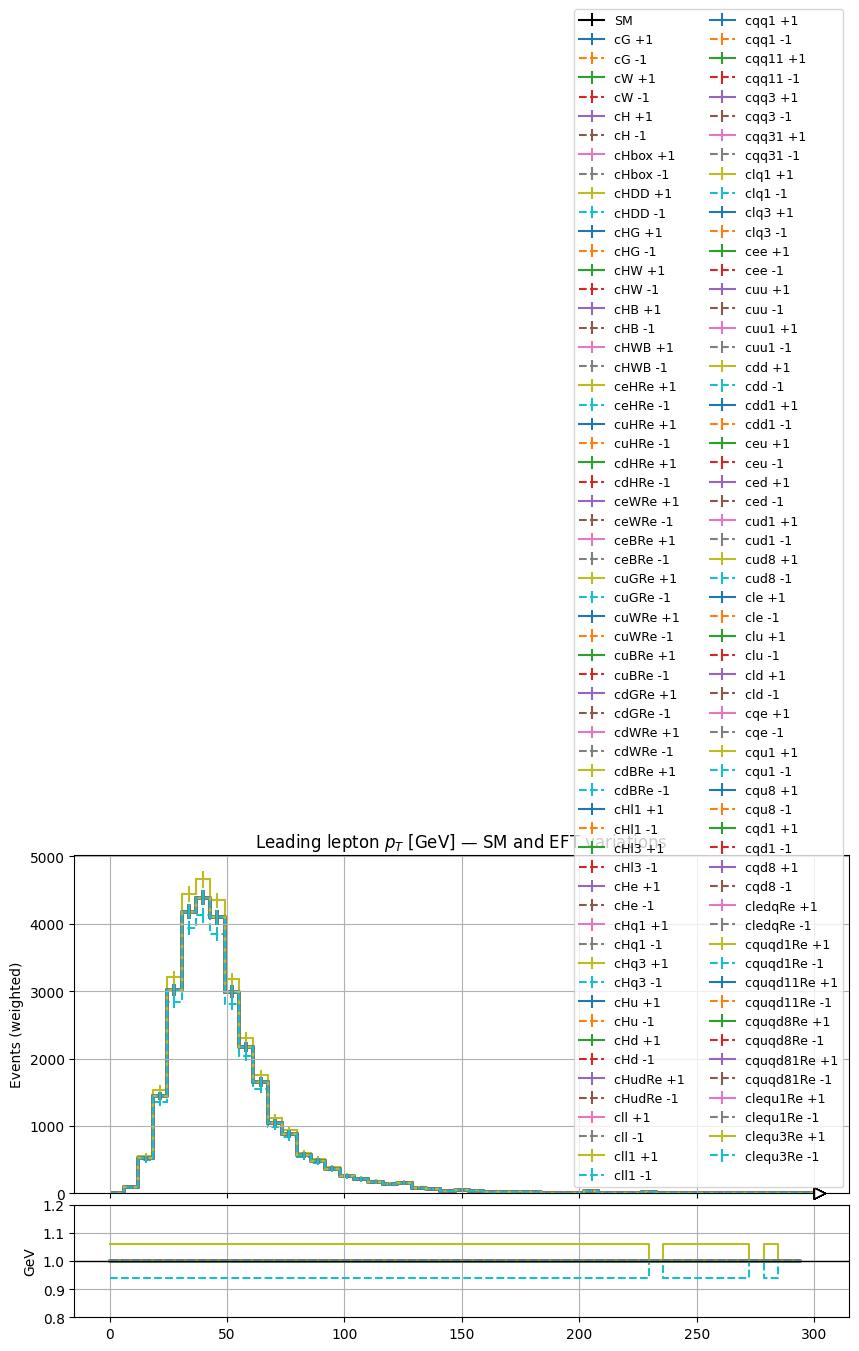

In [66]:
bins = np.linspace(0, 300, 50)
hists_ptlead = build_hist(leading_pt, weights, bins)
plot_histograms(hists_ptlead, "Leading lepton $p_T$ [GeV]", save_name="wleading_pt.png")

In [67]:
#Check
unique_pid = list(set(ak.flatten(pid[neutrinos])))
print("Unique PIDs:", unique_pid)

unique_nu_counts = list(set(ak.num(nu_pt)))
print("Unique neutrino multiplicities:", unique_nu_counts)

print("Neutrino PIDs in first 10 events:", pid[neutrinos][:10])
print("Unique neutrino status codes:", list(set(ak.flatten(status[neutrinos]))))


Unique PIDs: [np.int32(-14), np.int32(12), np.int32(-12), np.int32(14)]
Unique neutrino multiplicities: [np.int64(2)]
Neutrino PIDs in first 10 events: [[12, -12], [12, -12], [14, -14], [...], ..., [14, -12], [14, -12], [12, -12]]
Unique neutrino status codes: [np.int32(1)]


In [68]:
#Check
# Flatten and convert to Python list
flattened_pids = ak.flatten(pid[neutrinos]).to_list()
unique_pids = sorted(set(flattened_pids))
print("Unique PID values in neutrino selection:", unique_pids)

# Neutrino multiplicities
nu_counts = ak.num(nu_pt).to_list()
unique_nu_counts = sorted(set(nu_counts))
print("Unique neutrino multiplicities:", unique_nu_counts)

# First 10 events' neutrino PIDs
print("Neutrino PIDs in first 10 events:")
for i in range(10):
    print(pid[neutrinos][i].to_list())

# Unique neutrino status codes
flattened_status = ak.flatten(status[neutrinos]).to_list()
unique_status = sorted(set(flattened_status))
print("Unique neutrino status codes:", unique_status)


Unique PID values in neutrino selection: [-14, -12, 12, 14]
Unique neutrino multiplicities: [2]
Neutrino PIDs in first 10 events:
[12, -12]
[12, -12]
[14, -14]
[12, -14]
[12, -12]
[14, -12]
[14, -14]
[14, -12]
[14, -12]
[12, -12]
Unique neutrino status codes: [1]


In [69]:
#Check
for name, idx_p, idx_m in operators:
    w_p = weights[:, idx_p]
    w_m = weights[:, idx_m]

    print(f"Operator {name}:")
    print(f"  +1 weights: mean={np.mean(w_p):.3f}, std={np.std(w_p):.3f}, min={np.min(w_p):.3f}, max={np.max(w_p):.3f}")
    print(f"  -1 weights: mean={np.mean(w_m):.3f}, std={np.std(w_m):.3f}, min={np.min(w_m):.3f}, max={np.max(w_m):.3f}")
    print()

Operator cG:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cW:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cH:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cHbox:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cHDD:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cHG:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cHW:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.932, max=2.932

Operator cHB:
  +1 weights: mean=2.932, std=nan, min=2.932, max=2.932
  -1 weights: mean=2.932, std=nan, min=2.

In [70]:
def plot_histograms_log(hists, xlabel, save_name=None):

    sm = hists["SM"]

    # Prepare figure
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2,1, height_ratios=[3,1], hspace=0.05)

    # Top panel: SM + EFT overlays
    ax = fig.add_subplot(gs[0])

    sm.plot(ax=ax, label="SM", color='black')    

    for name, idx_p, idx_m in operators:
        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p.plot(ax=ax, label=f"{name} +1", overlay=True)
        h_m.plot(ax=ax, label=f"{name} -1", linestyle='--', overlay=True)

    ax.set_yscale("log")
    ax.set_ylabel("Events (weighted)")
    ax.set_title(xlabel + " — SM and EFT variations")
    ax.legend(ncol=2, fontsize=9)

    # Bottom panel: EFT/SM ratios
    ax2 = fig.add_subplot(gs[1], sharex=ax)

    sm_values = sm.values()
    bins = sm.axes[0].edges

    for name, idx_p, idx_m in operators:

        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p_val = h_p.values()
        h_m_val = h_m.values()

        # SAFE division (NumPy arrays, no structured dtype)
        ratio_p = np.divide(h_p_val, sm_values, out=np.ones_like(h_p_val), where=sm_values != 0)
        ratio_m = np.divide(h_m_val, sm_values, out=np.ones_like(h_m_val), where=sm_values != 0)

        # Plot
        ax2.step(bins[:-1], ratio_p, label=f"{name} +1", where="mid")
        ax2.step(bins[:-1], ratio_m, label=f"{name} -1", linestyle='--', where="mid")

    ax2.axhline(1.0, color='black', linewidth=1)
    ax2.set_ylabel("EFT / SM")
    ax2.set_ylabel("GeV")
    ax2.set_ylim(0.8, 1.2)

    if save_name:
        plt.savefig(save_name, dpi=200)
        print(f"Saved plot: {save_name}")

    plt.show()


Saved plot: wleading_pt_log.png


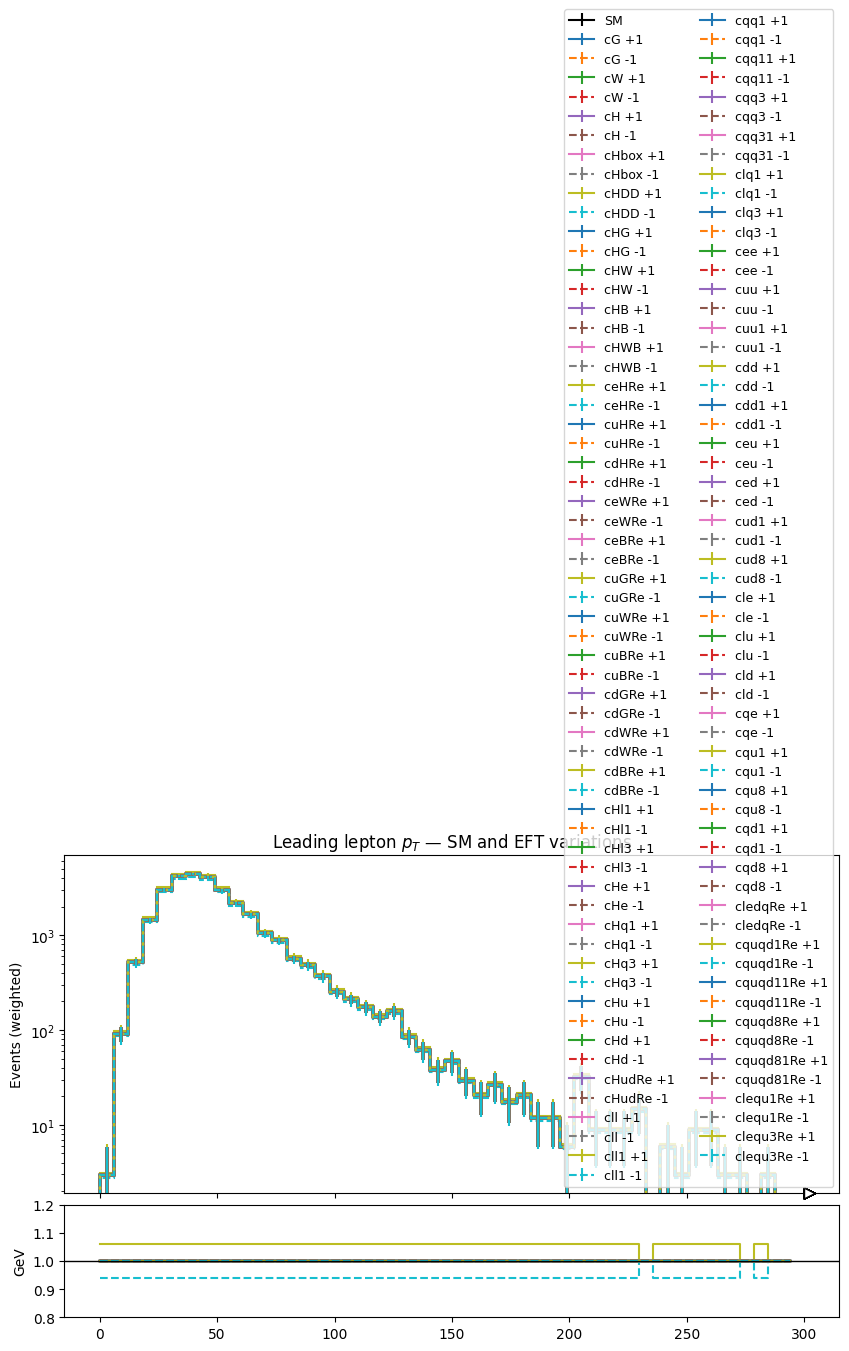

Saved plot: wZ_pt_log.png


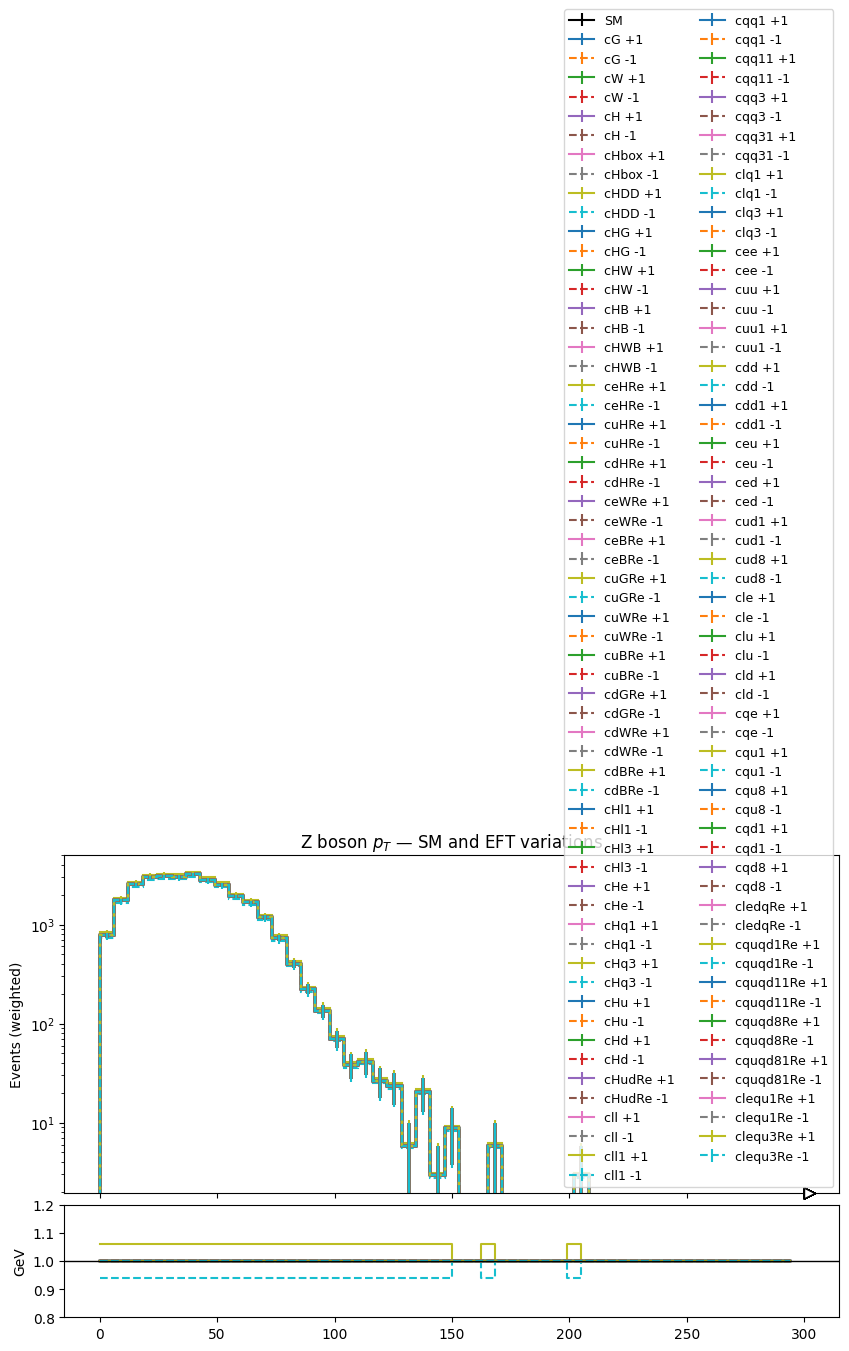

Saved plot: wMET_log.png


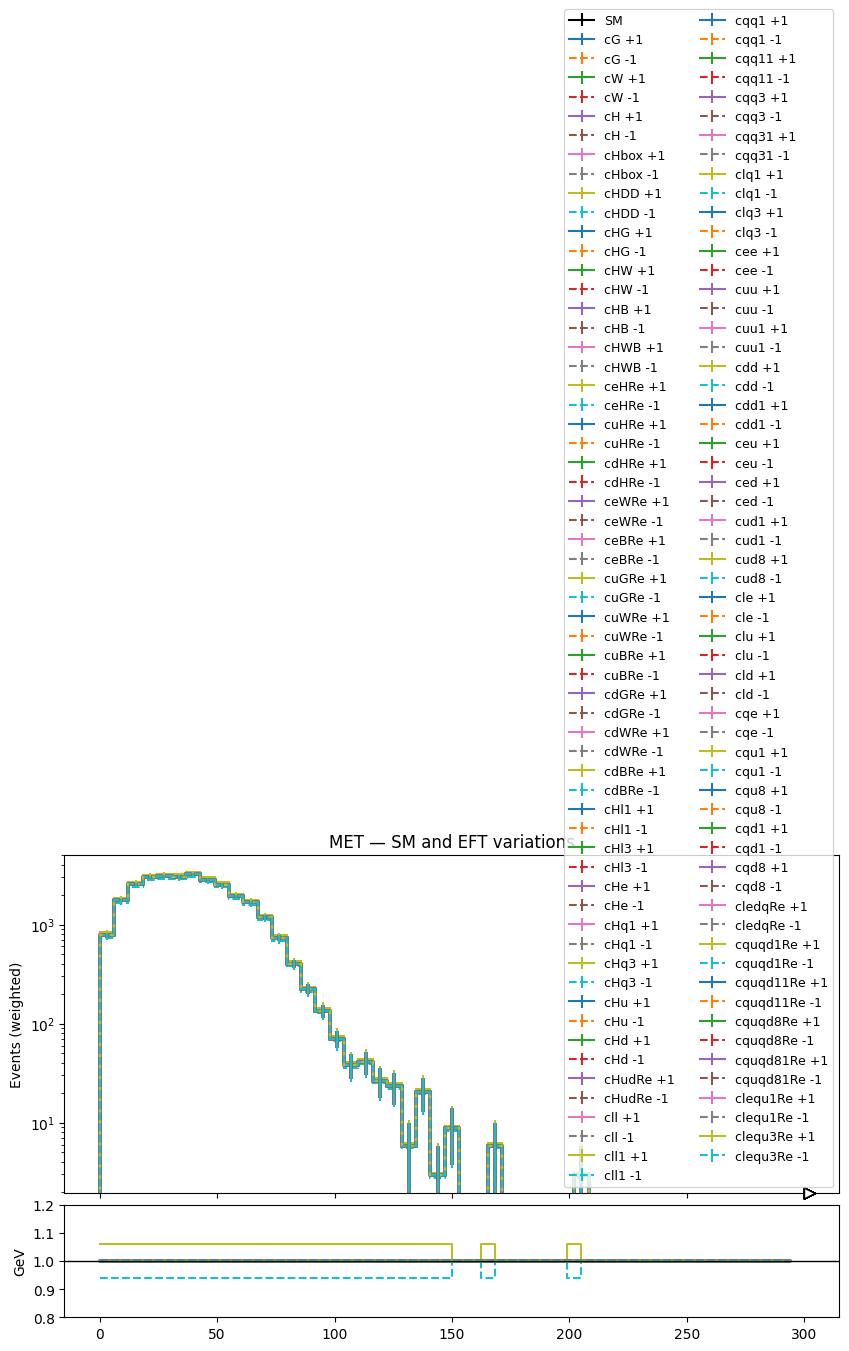

Saved plot: wtrailing_pt.png


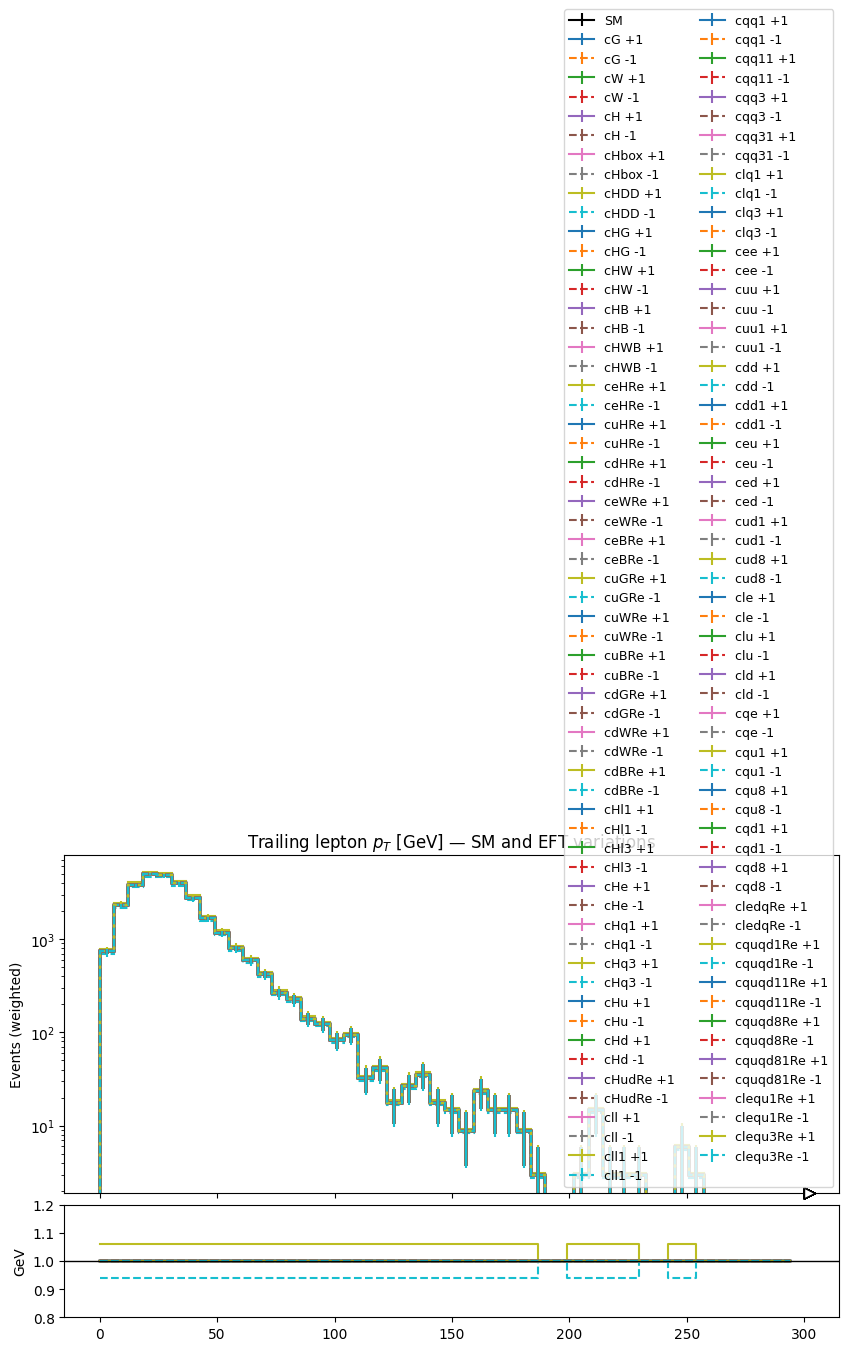

Saved plot: weta1.png


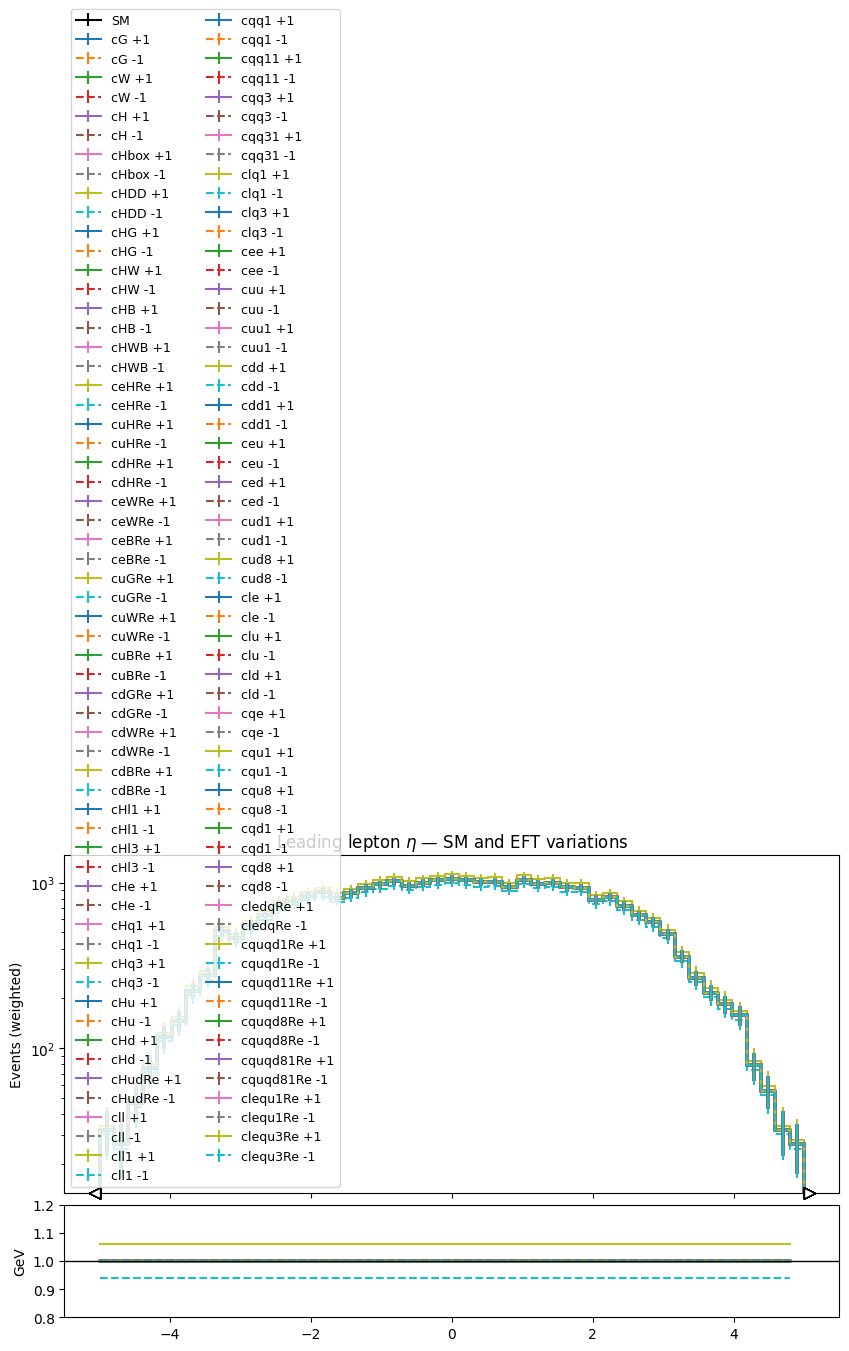

Saved plot: weta2.png


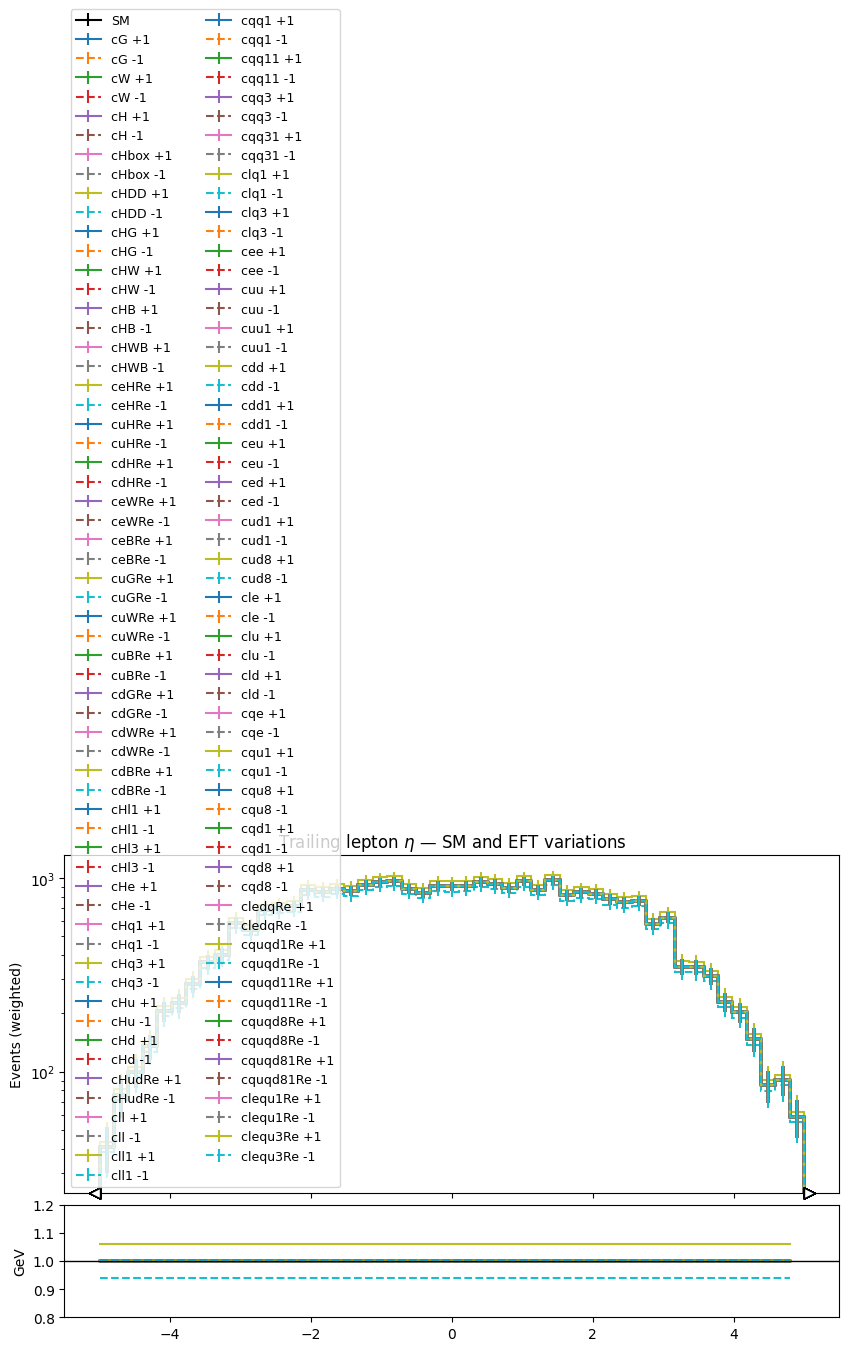

In [71]:
h_ptlead = build_hist(leading_pt, weights, bins)
plot_histograms_log(h_ptlead, "Leading lepton $p_T$", save_name="wleading_pt_log.png")

h_Z = build_hist(Z_pt, weights, bins)
plot_histograms_log(h_Z, "Z boson $p_T$", save_name="wZ_pt_log.png")

h_MET = build_hist(MET, weights, bins)
plot_histograms_log(h_MET, "MET", save_name="wMET_log.png")

h_trailing = build_hist(trailing_pt, weights, bins)
plot_histograms_log(h_trailing, "Trailing lepton $p_T$ [GeV]", save_name="wtrailing_pt.png")

bins_eta = np.linspace(-5, 5, 50)

h_eta1 = build_hist(eta1, weights, bins_eta)
plot_histograms_log(h_eta1, "Leading lepton $\eta$", save_name="weta1.png")

h_eta2 = build_hist(eta2, weights, bins_eta)
plot_histograms_log(h_eta2, "Trailing lepton $\eta$", save_name="weta2.png")